In [1]:
# import stuff
import os
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.visualizer import SamplingVisualizer, visualize_covariance_to_axis
from uncertainty_motion_prediction.predictor.hmm_latent_segments import (
    segmentize_trajectory, normalise_segment, normalise_segment_batch
)

In [2]:
dataset=Dataloader();
dataset_index = 0
traj_dataset = dataset.load(dataset_index)

## As numpy array

In [3]:
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Hidden Markov Model with trajectory sub-segment latent states

This method works by modelling a pedestrian trajectory as being composed of multiple common segment primitives. Developing the HMM model consists of 2 parts:
* Extracting common trajectory sub-segments from data. These sub-segments or segment primitives will be the states of the HMM.
* Learn the transition matrix of the HMM. To predict the pedestrian's trajectory, we need the ability to predict the next state or segment primitive the pedestrian will transit to after the current segment the pedestrian is executing.

## Sanity checks

We perform some sanity checks on artificial data first to validate the HMM algorithm. Generate the artificial trajectories from a set of 5 different trajectory types

In [4]:
seg_type1 = [[0, 0, 1, 0], [1, 0, 5, 0], [6, 0, 5, 0]]
seg_type2 = [[0, 0, 1, 0], [1, 0, 1, 0], [2, 0, 1, 0]]
seg_type3 = [[0, 0, 1, 0], [1, 0, 1, 1], [2, 1, 1, 1]]
seg_type4 = [[0, 0, 1, 0], [1, 0, 1, -1], [2, -1, 1, -1]]
seg_type5 = [[0, 0, 1, 0], [1, 0, -2, 0], [-1, 0, -2, 0]]

seg_types = np.array([seg_type1, seg_type2, seg_type3, seg_type4, seg_type5])
test_trajs = []

for seg_type in seg_types:
    for i in range(3):
        angle = np.random.uniform(-2*np.pi, 2*np.pi)
        scale = np.random.uniform(0.5, 1.5)
        trans = np.array([[np.random.uniform(-10, 10), np.random.uniform(-10, 10)]]).T

        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        S = np.array([[scale, 0], 
                      [0, scale]])

        seg = np.dot(S, np.dot(R, seg_type[:, 0:2].T))
        seg = seg + trans
        seg_vels = np.dot(S, np.dot(R, seg_type[:, 2:].T))
        sample = np.hstack((seg.T, seg_vels.T))
        test_trajs.append(sample)
        
print(test_trajs)
print(np.array(test_trajs).shape)

[array([[-0.91656904, -1.94359983, -0.07344768,  1.26515404],
       [-0.99001672, -0.67844579, -0.36723838,  6.32577018],
       [-1.35725509,  5.64732439, -0.36723838,  6.32577018]]), array([[ 3.56195108, -3.24819311,  0.34428144, -0.69387968],
       [ 3.90623252, -3.94207279,  1.7214072 , -3.4693984 ],
       [ 5.62763971, -7.41147119,  1.7214072 , -3.4693984 ]]), array([[ 9.24432292,  1.12128489, -0.02745748,  0.83014991],
       [ 9.21686544,  1.9514348 , -0.13728739,  4.15074955],
       [ 9.07957805,  6.10218436, -0.13728739,  4.15074955]]), array([[-1.23361503,  0.14478975, -0.21306145,  0.49955903],
       [-1.44667649,  0.64434878, -0.21306145,  0.49955903],
       [-1.65973794,  1.14390781, -0.21306145,  0.49955903]]), array([[ 0.66216305,  1.31142249, -0.11101924,  0.65793364],
       [ 0.55114381,  1.96935613, -0.11101924,  0.65793364],
       [ 0.44012458,  2.62728977, -0.11101924,  0.65793364]]), array([[-5.00129771, -9.20779577, -0.50371333,  0.0368871 ],
       [-5.50

Test the performance of the clustering step. The code implements 2 different ways to do this: 1) X-means which automatically selects the optimal number of clusters using Bayesian Information Criterion, 2) iterative K-means over a range of possible numbers of clusters, with the user left to select the optimal number of clusters manually from the extracted distance-to-centroid and silhouette methods.

We test (2), since the X-means approach with BIC seems prone to over-clustering.

Text(0.5, 1.0, 'Silhouette scores')

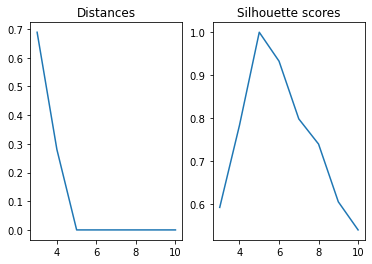

In [5]:
extractor = HMMLatentSegmentsExtractor(segment_len=3)

dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(np.array(test_trajs))
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [6]:
clustering_tmp = KMeansOutcome(3, centres[2])
clustering_tmp.save_to_file("./tmp_clustering.pickle")
clustering = KMeansOutcome.load_from_file("./tmp_clustering.pickle")
print(clustering.N)
clustering.classify_batch(test_trajs)

5


[2, 2, 2, 0, 0, 0, 3, 3, 3, 4, 4, 4, 1, 1, 1]

In [7]:
centres[2]

[[0.0,
  0.49999999999999983,
  1.0,
  0.0,
  2.49889681061418e-16,
  -1.6478549115061672e-16],
 [0.0,
  0.19371294336139658,
  -0.19371294336139658,
  0.0,
  -1.1727300322718725e-17,
  -1.602827529291019e-17],
 [0.0,
  0.10961179679779244,
  0.6576707807867547,
  0.0,
  -5.346165736847558e-19,
  1.880492276664159e-17],
 [0.0,
  0.3535533905932738,
  0.7071067811865475,
  0.0,
  -6.155639332677443e-17,
  0.35355339059327373],
 [0.0,
  0.3535533905932739,
  0.7071067811865475,
  0.0,
  2.4869746837004647e-17,
  -0.3535533905932738]]

## Learn segments from data

In [8]:
segment_length = 4
estimate_velocity = True
trajlets_for_segments_learning = traj_dataset.get_trajlets(length=segment_length*0.4, overlap=1, to_numpy=True)
print(trajlets_for_segments_learning.shape)

(3478, 4, 5)


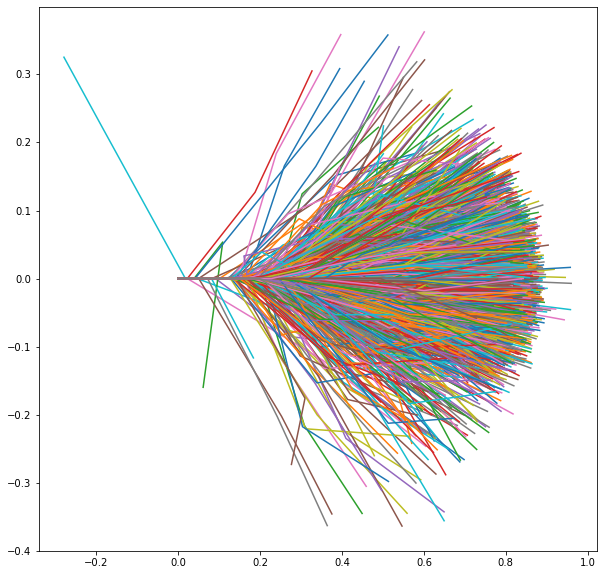

In [9]:
trajlets_for_segments_learning_normalized = normalise_segment_batch(
    trajlets_for_segments_learning, segment_length, estimate_vel=True
)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in trajlets_for_segments_learning_normalized:
    axs.plot(p[0:segment_length], p[segment_length:])

In [10]:
extractor = HMMLatentSegmentsExtractor(
    segment_len=segment_length, n_min_centres=10, n_max_centres=100, estimate_velocity=estimate_velocity
)
dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(
    trajlets_for_segments_learning[:, :, 0:4]
)
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

Text(0.5, 1.0, 'Silhouette scores')

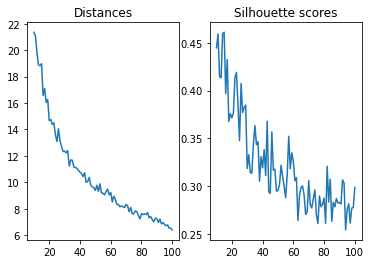

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [12]:
center_idx = 30
print(dists[center_idx])
center = np.array(centres[center_idx])
clustering = KMeansOutcome(segment_length, center, estimate_velocity=estimate_velocity)
clustering.save_to_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
print(clustering.N)

10.773831876135066
40


In [13]:
patterns = center.reshape([-1, 2, segment_length])
print(patterns.shape)

(40, 2, 4)


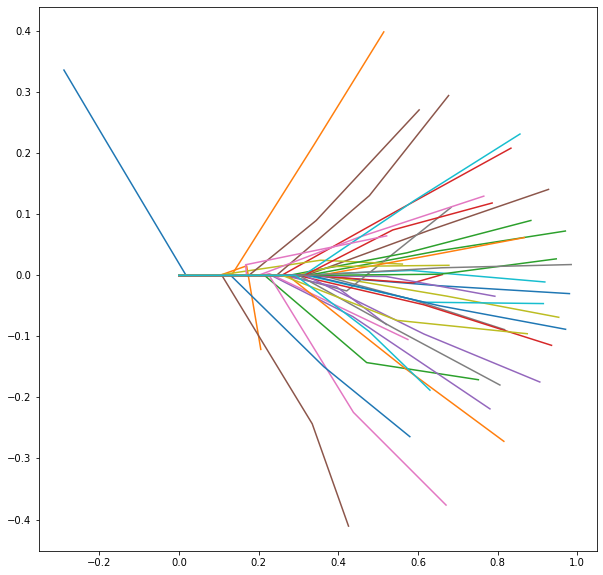

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in patterns[:, :, :]:
    axs.plot(p[0, :], p[1, :])

## Learn HMM model

In [15]:
segment_length = 4
num_segment = 10
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
assert clustering.segment_length == segment_length
traj_length = num_segment * (segment_length - 1) + 1
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length= traj_length * 0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(54, 31, 5)


In [16]:
# print(trajlets_for_hmm_learning[0, 0:12, 0:4])
# print(trajlets_for_hmm_learning[0, 0:12, 0:4].reshape([3, 4, 4]))

In [17]:
observations = []
for t in trajlets_for_hmm_learning:
    segments = segmentize_trajectory(t, segment_length)
    obs = clustering.classify_batch(segments)
    observations.append(obs)

In [18]:
observations

[[13, 27, 30, 37, 0, 39, 36, 18, 22, 5],
 [26, 19, 23, 34, 19, 7, 2, 28, 25, 19],
 [28, 27, 28, 3, 22, 12, 34, 12, 22, 37],
 [37, 0, 12, 12, 5, 12, 5, 12, 12, 5],
 [12, 22, 29, 32, 30, 37, 37, 37, 37, 0],
 [37, 37, 5, 22, 0, 37, 12, 37, 37, 9],
 [37, 37, 32, 0, 8, 0, 0, 37, 12, 12],
 [12, 22, 22, 37, 37, 23, 8, 22, 12, 14],
 [0, 8, 5, 12, 9, 34, 19, 23, 2, 29],
 [1, 1, 36, 1, 35, 25, 27, 21, 33, 34],
 [21, 33, 34, 22, 22, 34, 9, 16, 39, 13],
 [35, 27, 5, 9, 34, 22, 23, 30, 21, 9],
 [30, 21, 9, 12, 4, 1, 28, 1, 1, 36],
 [37, 34, 19, 37, 37, 32, 12, 0, 21, 32],
 [38, 12, 12, 22, 5, 37, 23, 19, 19, 22],
 [21, 21, 14, 9, 0, 34, 0, 12, 12, 14],
 [24, 7, 1, 24, 24, 24, 36, 1, 24, 1],
 [1, 24, 1, 1, 24, 24, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 24, 18, 39, 1, 1],
 [39, 1, 1, 1, 1, 35, 14, 14, 14, 24],
 [19, 34, 0, 0, 12, 22, 0, 12, 12, 21],
 [23, 30, 30, 0, 12, 29, 9, 0, 34, 31],
 [2, 3, 29, 30, 8, 30, 0, 9, 14, 27],
 [9, 14, 27, 4, 35, 24, 1, 24, 1, 36],
 [24, 1, 36, 1, 18, 24, 24, 35, 10, 1],
 [7, 

In [ ]:
state_dim = 50
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=30)
try:
    hmm.load_from_file("./hmm_model_param_%d.pickle" %dataset_index)
except Exception as e:
    print("Fail to load parameters. Maybe they do not exist yet.")
    print(e)
hmm.estimate_parameters(np.array(observations))
hmm.save_to_file("./hmm_model_param_%d.pickle" %dataset_index)

Fail to load parameters. Maybe they do not exist yet.
[Errno 2] No such file or directory: '/home/kurisu/nus-cs5340/notebooks/hmm_model_param_0.pickle'
Estimating HMM model parameters...
Iter 1, log-likelihood loss: -36.72488817978487, delta: inf
Iter 2, log-likelihood loss: -32.50171332967108, delta: 4.223174850113793
Iter 3, log-likelihood loss: -32.339748618320336, delta: 0.1619647113507412
Iter 4, log-likelihood loss: -32.070939688959086, delta: 0.2688089293612492
Iter 5, log-likelihood loss: -31.46483638697135, delta: 0.6061033019877371
Iter 6, log-likelihood loss: -30.238219292425153, delta: 1.2266170945461958
Iter 7, log-likelihood loss: -28.78829027613126, delta: 1.4499290162938934
Iter 8, log-likelihood loss: -27.710375559424737, delta: 1.0779147167065233
Iter 9, log-likelihood loss: -26.69673554868452, delta: 1.0136400107402181
Iter 10, log-likelihood loss: -25.57965272480117, delta: 1.1170828238833472
Iter 11, log-likelihood loss: -24.370569420737816, delta: 1.20908330406335

## Deploy the learned model

### Predict

In [ ]:
clustering = KMeansOutcome.load_from_file("./hmm_segment_clustering_%d.pickle" %dataset_index)
state_dim = 50
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
hmm.load_from_file("./hmm_model_param_%d.pickle" %dataset_index)
predictor = HMMLatentSegmentsPredictor(hmm, clustering)

In [ ]:
segment_length = 4
num_segment = 4
num_history_segment = 3
traj_length = num_segment * (segment_length - 1) + 1
history_traj_length = num_history_segment * (segment_length - 1) + 1
trajlets_for_testing = traj_dataset.get_trajlets(
    length=traj_length * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

In [ ]:
traj = trajlets_for_testing[1]
print(traj[:, 0:2])
predicted = predictor.predict(traj[0:history_traj_length, :])
print(predicted)

In [ ]:
predicted_center_idx = clustering.classify(predicted)
print(predicted_center_idx)

In [ ]:
# center = np.array(clustering._centers[predicted_center_idx]).reshape([2, -1]).T
# print(center)
# fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.plot(traj[:, 0] - traj[0, 0], traj[:, 1] - traj[0, 1])
# axs.plot(center[:, 0], center[:, 1])

### Evaluation of point estimate error

In [ ]:
evaluator = DistanceErrorEvaluator(N_future=4, N_history=history_traj_length)

In [ ]:
result = evaluator.evaluate(predictor, trajlets_for_testing)
print(result)

In [ ]:
evaluator.hist()

### Evaluation fo uncertainty

In [ ]:
import matplotlib.pyplot as plt

viz = SamplingVisualizer(N_future=4, N_history=history_traj_length, sample_size=1000)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

idx = np.random.randint(0, trajlets_for_testing.shape[0])
print(f"Index: {idx}")
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(axs, predictor, traj)
axs.set_aspect(1)